In [4]:

import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()


class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [81]:
#cpuで１時間はかかる。
BSV = BertSequenceVectorizer() # インスタンス化します

train_1 = pd.read_csv('train.csv')
# null は代わりのもので埋めます
train_1['description'] = train_1['description'].fillna("NaN")
train_1['description_feature'] = train_1['description'].progress_apply(lambda x: BSV.vectorize(x))
train_1[['object_id', 'description', 'description_feature']].head()

#train_1としているのは、trainのままにしていると
#操作を誤った時にまた１時間かかる恐れがあるから。

100%|██████████| 12026/12026 [2:16:37<00:00,  1.47it/s] 


,object_id,description,description_feature
0,0011d6be41612ec9eae3,NaN,"[-0.04250159, 0.036861505, 0.039393608, 0.0547..."
1,0012765f7a97ccc3e9e9,NaN,"[-0.04250159, 0.036861505, 0.039393608, 0.0547..."
2,0017be8caa87206532cb,"Portret van eenvrouw, zittend naast een tafel.","[-0.63844216, 0.12233404, 0.16228917, -0.46431..."
3,00181d86ff1a7b95864e,"Een sint-bernardshond, staand in een landschap...","[-0.6219215, -0.25778952, 0.13090691, -0.17220..."
4,001c52ae28ec106d9cd5,Woelige zee met zeilschepen.,"[-0.82783353, 0.09303975, -0.10044706, -0.4505..."


In [82]:
np.stack(train_1['description_feature']).shape

(12026, 768)

In [88]:
#念の為さらにコピーを準備
train_2 = train_1.copy()
#とりあえずそのまま保存してみる
train_2.to_csv("practise.csv")

In [5]:
df_1 = pd.read_csv("practise.csv")

In [8]:
#なぜか"description_feature"がstrとして保存されてしまう
#しかも、一行に入ってる７６８この数値が,(コンマ)で区切られていなくなる
type(df_1["description_feature"][0])
#ここでtrain_2が活きてくる

str

In [17]:
#こっちはおそらく、arrayが返ってくる（）し,で区切られてる
type(train_2["description_feature"][0])

NameError: name 'train_2' is not defined

In [95]:
def create_input_array_pca(input_df):
    features = []
    for array in input_df['description_feature']:
        features.append(array)
    return pd.DataFrame(features).values.astype(np.float32)

In [100]:
#train_1やtrain_2の状態じゃないと（一度保存してしまうと）
#strからflootへは変換できないとのerrorがでる
x = create_input_array_pca(train_2)
x.shape, x.dtype

((12026, 768), dtype('float32'))

In [101]:
from sklearn.decomposition import PCA

In [102]:
def result_description_pca(N):
    pca = PCA(n_components=N).fit(x)
    transformed = pca.transform(x)
    for n in range(N):
        print(f'第 {n+1} 主成分：{pca.explained_variance_ratio_[n]}')
    return pd.DataFrame(transformed)

第 1 主成分：0.5645531415939331
第 2 主成分：0.1739821881055832


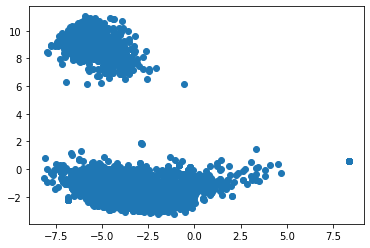

In [103]:
result_feature = result_description_pca(N=2)
plt.scatter(result_feature[0], result_feature[1]);

In [107]:
result_feature.columns = ["PCA1","PCA"]

In [115]:
#くっつけて保存する
df_PCA = pd.concat([train_2,result_feature],axis = 1)
df_PCA

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,...,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,description_feature,PCA1,PCA
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,...,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,"[-0.04250159, 0.036861505, 0.039393608, 0.0547...",8.335307,0.610747
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,...,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,"[-0.04250159, 0.036861505, 0.039393608, 0.0547...",8.335307,0.610747
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,...,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,"[-0.63844216, 0.12233404, 0.16228917, -0.46431...",-1.475386,-2.416382
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,...,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100,"[-0.6219215, -0.25778952, 0.13090691, -0.17220...",1.409902,-1.233963
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,...,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7,"[-0.82783353, 0.09303975, -0.10044706, -0.4505...",-1.516181,-2.953952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,...,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4,"[-0.04250159, 0.036861505, 0.039393608, 0.0547...",8.335307,0.610747
12022,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",...,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0,"[-0.8884068, -0.027215105, 0.040976785, -0.565...",-4.618852,-1.087326
12023,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,...,NaN,1778,1778.0,18,1778.0,1778.0,0,"[-0.89676154, 0.082224615, 0.00653382, -0.3987...",-2.262538,-1.980103
12024,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",...,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14,"[-0.2011421, 0.23096186, -0.038344692, -0.2893...",-5.922931,9.162237


In [120]:
#csvにする。
df_PCA.to_csv("train_PCA.cs")

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,...,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,description_feature,PCA1,PCA
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,...,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,"[-0.04250159, 0.036861505, 0.039393608, 0.0547...",8.335307,0.610747
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,...,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,"[-0.04250159, 0.036861505, 0.039393608, 0.0547...",8.335307,0.610747
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,...,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,"[-0.63844216, 0.12233404, 0.16228917, -0.46431...",-1.475386,-2.416382
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,...,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100,"[-0.6219215, -0.25778952, 0.13090691, -0.17220...",1.409902,-1.233963
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,...,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7,"[-0.82783353, 0.09303975, -0.10044706, -0.4505...",-1.516181,-2.953952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,...,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4,"[-0.04250159, 0.036861505, 0.039393608, 0.0547...",8.335307,0.610747
12022,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",...,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0,"[-0.8884068, -0.027215105, 0.040976785, -0.565...",-4.618852,-1.087326
12023,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,...,NaN,1778,1778.0,18,1778.0,1778.0,0,"[-0.89676154, 0.082224615, 0.00653382, -0.3987...",-2.262538,-1.980103
12024,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",...,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14,"[-0.2011421, 0.23096186, -0.038344692, -0.2893...",-5.922931,9.162237


In [129]:
pd.DataFrame(df_PCA['description_feature']).to_csv('test.csv')

In [134]:
df_5 = pd.read_csv('des.csv')

In [138]:
df_5["description_feature"][0]

'[-4.25015911e-02  3.68615054e-02  3.93936075e-02  5.47836944e-02\n -5.56198210e-02 -1.53118476e-01  1.00209489e-02  1.73584625e-01\n -7.79053196e-04 -1.21945284e-01 -1.32826507e-01 -1.51562970e-02\n  8.97438172e-03  2.94369996e-01  1.54609933e-01 -5.19811995e-02\n  3.41169760e-02  1.23676099e-01  1.62847430e-01 -2.85701156e-01\n  9.91699174e-02 -3.78397517e-02 -1.51670307e-01 -6.90223277e-02\n -6.38792738e-02 -6.51218593e-02 -1.14934742e-01 -1.01777628e-01\n  8.14238116e-02  1.68284327e-01 -8.74336287e-02  1.21832892e-01\n -1.15365945e-01  2.26834893e-01 -1.61007103e-02  5.98414391e-02\n -2.57868078e-02 -7.01999143e-02 -1.10003399e-03  1.45014599e-01\n  5.65497130e-02 -1.13951989e-01  1.17424071e-01 -4.21513468e-02\n  4.21648920e-02  2.36817785e-02 -1.30743086e+00 -1.25090301e-01\n -2.04816669e-01 -7.31480718e-02  6.71816617e-03 -2.28743285e-01\n  1.80077747e-01  2.12691724e-01 -1.18237831e-01  1.41698167e-01\n -6.26878068e-02  4.81169254e-01  1.28970072e-01  1.13186300e-01\n  2.28813